In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Reshape, Conv1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras import optimizers, layers, regularizers
from sklearn.metrics import classification_report
AUTOTUNE = tf.data.experimental.AUTOTUNE


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# pth = '/content/drive/My Drive/Colab Notebooks/pollen_data/train/images/'

In [ ]:
# os.listdir(pth)

In [ ]:
# data = []

# for folder in os.listdir(pth):
#   print(folder)
#   count = 0
#   for subfolder in os.listdir(pth+folder):
#     print(subfolder)
#     if subfolder=='train_OBJ':
#       one_hot_label = np.zeros(4)
#       one_hot_label[int(folder)-1] = 1
#       for image in os.listdir(pth+folder+'/'+subfolder):
#         count += 1
#         if count % 100 == 0 : print(count) 
#         img_matrix = cv2.imread(pth+folder+'/'+subfolder+'/'+image)
#         data.append([img_matrix, one_hot_label])


In [ ]:
# np.save('data.npy', data)
data = np.load('/content/drive/My Drive/Colab Notebooks/data.npy', allow_pickle=True)

In [ ]:
np.shape(data)

(4808, 2)

In [ ]:
# count = 0
# train_dataset = []
# test_dataset = []

# for d in data:
#   count+=1
#   if count<4000:
#     train_dataset.append(d)
#   else:
#     test_dataset.append(d)
  
# print(np.shape(train_dataset), np.shape(test_dataset))

In [ ]:
c = np.zeros(4)
for d in data:
  c += d[1]
print('Number of images from every class-',c)
print(np.sum(c))

print(np.shape(data))
print(np.shape(data[0]))
print(np.shape(data[0][0]))
print(np.shape(data[0][1]))

Number of images from every class- [1566.  773. 1745.  724.]
4808.0
(4808, 2)
(2,)
(84, 84, 3)
(4,)


In [ ]:
len(data)

4808

In [ ]:
# Data augmentation

aug_data = data
temp = []

for i in range(len(data)):
  
  image = data[i][0]
  label = data[i][1]

  flip_image = np.fliplr(image)
  temp = np.transpose(np.asarray([[flip_image], [label]]))
  aug_data = np.concatenate((aug_data, temp))

  flip_image2 = np.flipud(image)
  temp = np.transpose(np.asarray([[flip_image2], [label]]))
  aug_data = np.concatenate((aug_data, temp))

  # flip_image = tf.image.flip_left_right(image)
  # temp = np.transpose(np.asarray([[flip_image], [label]]))
  # aug_data = np.concatenate((aug_data, temp))

  # flip_image2 = tf.image.flip_up_down(image)
  # temp = np.transpose(np.asarray([[flip_image2], [label]]))
  # aug_data = np.concatenate((aug_data, temp))

  # cropped = tf.image.central_crop(image, central_fraction=0.8)
  # temp = [cropped, label]
  # aug_data.append(temp)

print(np.shape(aug_data), np.shape(data))

(14424, 2) (4808, 2)


In [ ]:
c = np.zeros(4)
for d in data:
  c += d[1]
print('Number of images from every class-',c)
print(np.sum(c))

c = np.zeros(4)
for d in aug_data:
  c += d[1]
print('Number of images from every class-',c)
print(np.sum(c))

Number of images from every class- [1566.  773. 1745.  724.]
4808.0
Number of images from every class- [4698. 2319. 5235. 2172.]
14424.0


In [ ]:
# shuffle

np.random.seed(1)
np.random.shuffle(aug_data)

print(np.shape(aug_data))

(14424, 2)


In [ ]:
# X and t from data

train_X = []
train_t = []
test_X = []
test_t = []
counter=0

for images, labels in aug_data:
  counter+=1
  if counter < 12000:
    train_X.append(images)
    train_t.append(labels)
  else:
    test_X.append(images)
    test_t.append(labels)


In [ ]:
print(np.shape(train_X), np.shape(train_t), np.shape(test_X), np.shape(test_t))

(11999, 84, 84, 3) (11999, 4) (2425, 84, 84, 3) (2425, 4)


In [ ]:
# Normalizing the images

train_X = np.asarray(train_X)/255
train_t = np.asarray(train_t)

test_X = np.asarray(test_X)/255
test_t = np.asarray(test_t)

print(np.shape(train_X), np.shape(train_t), np.shape(test_X), np.shape(test_t))

(11999, 84, 84, 3) (11999, 4) (2425, 84, 84, 3) (2425, 4)


In [ ]:
# Baseline CNN model

input_layer = Input(shape=(84,84,3), name='input')
conv1 = Conv2D(16, kernel_size=5, activation='relu', name='conv1', kernel_regularizer=regularizers.l2(0.001))(input_layer)
pool1 = MaxPooling2D(pool_size=(2,2), name='pool1')(conv1)
conv2 = Conv2D(32, kernel_size=5, activation='relu', name='conv2', kernel_regularizer=regularizers.l2(0.001))(pool1)
pool2 = MaxPooling2D(pool_size=(2,2), name='pool2')(conv2)
conv3 = Conv2D(64, kernel_size=5, activation='relu', name='conv3', kernel_regularizer=regularizers.l2(0.001))(pool2)
pool3 = MaxPooling2D(pool_size=(2,2), name='pool3')(conv3)
conv4 = Conv2D(128, kernel_size=5, activation='relu', name='conv4', kernel_regularizer=regularizers.l2(0.001))(pool3)
flat = Flatten()(conv4)
fc1 = Dense(100, activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.01))(flat)
fc2 = Dense(20, activation='relu', name='fc2', kernel_regularizer=regularizers.l2(0.01))(fc1)
fc3 = Dense(4, activation='softmax', name='fc3', kernel_regularizer=regularizers.l2(0.0001))(fc2)

model1 = Model(inputs=input_layer, outputs=fc3, name='Baseline_CNN_model')

In [ ]:
print(model1.summary())

Model: "Baseline_CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 84, 84, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 16)        1216      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 40, 40, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 36, 36, 32)        12832     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 18, 18, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 64)        51264     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 7, 7, 64)   

In [ ]:
# adam = optimizers.Adam(learning_rate=0.0005)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
m1 = model1.fit(train_X, train_t, batch_size=100, epochs=50, validation_split=0.2, shuffle=True)

Epoch 1/50
96/96 [==============================] - 2s 23ms/step - loss: 1.8782 - accuracy: 0.4878 - val_loss: 1.1107 - val_accuracy: 0.6621
Epoch 2/50
96/96 [==============================] - 2s 21ms/step - loss: 0.9410 - accuracy: 0.7013 - val_loss: 0.9068 - val_accuracy: 0.6850
Epoch 3/50
96/96 [==============================] - 2s 21ms/step - loss: 0.7587 - accuracy: 0.7687 - val_loss: 0.6461 - val_accuracy: 0.8158
Epoch 4/50
96/96 [==============================] - 2s 20ms/step - loss: 0.6738 - accuracy: 0.8020 - val_loss: 0.6005 - val_accuracy: 0.8379
Epoch 5/50
96/96 [==============================] - 2s 21ms/step - loss: 0.5746 - accuracy: 0.8421 - val_loss: 0.5433 - val_accuracy: 0.8692
Epoch 6/50
96/96 [==============================] - 2s 21ms/step - loss: 0.5372 - accuracy: 0.8628 - val_loss: 0.4986 - val_accuracy: 0.8796
Epoch 7/50
96/96 [==============================] - 2s 20ms/step - loss: 0.5028 - accuracy: 0.8735 - val_loss: 0.5214 - val_accuracy: 0.8796
Epoch 8/50
96

In [ ]:
test_y = model1.predict(test_X)

In [ ]:
y_true = np.array(tf.argmax(test_t, 1))
y_pred = np.array(tf.argmax(test_y, 1))

In [ ]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8835    0.8698    0.8766       776
           1     0.8938    0.8498    0.8712       406
           2     0.8632    0.9018    0.8821       896
           3     0.9027    0.8818    0.8921       347

    accuracy                         0.8800      2425
   macro avg     0.8858    0.8758    0.8805      2425
weighted avg     0.8805    0.8800    0.8800      2425



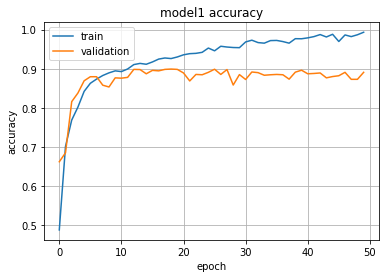

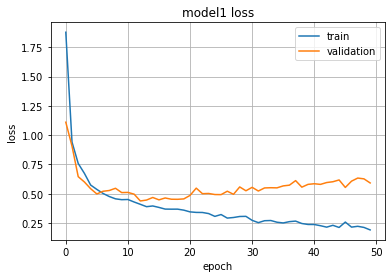

In [ ]:
plt.plot(m1.history['accuracy'])
plt.plot(m1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

plt.plot(m1.history['loss'])
plt.plot(m1.history['val_loss'])
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [ ]:
# Global reasoning module on the baseline model

input_layer = Input(shape=(84,84,3), name='input')
conv1 = Conv2D(16, kernel_size=5, activation='relu', name='conv1', kernel_regularizer=regularizers.l2(0.0005))(input_layer)

# Graph-based global reasoning module # input is 80x80x16
graph_transpose = Reshape((16, 80*80))(conv1)
squeezed_graph_transpose = Conv1D(100, 1, activation='relu', name='squeezer', kernel_regularizer=regularizers.l2(0.0001))(graph_transpose)
squeezed_graph = Reshape((100, 16))(squeezed_graph_transpose)
gconv = Conv1D(8, 1, activation='relu', name='gconv', kernel_regularizer=regularizers.l2(0.0001))(squeezed_graph)
gconv_transpose = Reshape((8, 100))(gconv)
unsqueezed_graph_transpose = Conv1D(6400, 1, activation='relu', name='unsqueezer', kernel_regularizer=regularizers.l2(0.0001))(gconv_transpose)
unsqueezed_graph = Reshape((6400, 8))(unsqueezed_graph_transpose)
glore_image = Reshape((80, 80, 8))(unsqueezed_graph)

block1 = layers.concatenate([conv1, glore_image], axis=-1)
pool1 = MaxPooling2D(pool_size=(2,2), name='pool1')(block1)
conv2 = Conv2D(32, kernel_size=5, activation='relu', name='conv2', kernel_regularizer=regularizers.l2(0.0005))(pool1)

# Graph-based global reasoning module 2 # input is 36x36x32
graph_transpose2 = Reshape((32, 36*36))(conv2)
squeezed_graph_transpose2 = Conv1D(100, 1, activation='relu', name='squeezer2', kernel_regularizer=regularizers.l2(0.0001))(graph_transpose2)
squeezed_graph2 = Reshape((100, 32))(squeezed_graph_transpose2)
gconv2 = Conv1D(16, 1, activation='relu', name='gconv2', kernel_regularizer=regularizers.l2(0.0001))(squeezed_graph2)
gconv_transpose2 = Reshape((16, 100))(gconv2)
unsqueezed_graph_transpose2 = Conv1D(36*36, 1, activation='relu', name='unsqueezer2', kernel_regularizer=regularizers.l2(0.0001))(gconv_transpose2)
unsqueezed_graph2 = Reshape((36*36, 16))(unsqueezed_graph_transpose2)
glore_image2 = Reshape((36, 36, 16))(unsqueezed_graph2)

block2 = layers.concatenate([conv2, glore_image2], axis=-1)
pool2 = MaxPooling2D(pool_size=(2,2), name='pool2')(block2)
conv3 = Conv2D(64, kernel_size=5, activation='relu', name='conv3', kernel_regularizer=regularizers.l2(0.0005))(pool2)
pool3 = MaxPooling2D(pool_size=(2,2), name='pool3')(conv3)
conv4 = Conv2D(128, kernel_size=5, activation='relu', name='conv4', kernel_regularizer=regularizers.l2(0.0005))(pool3)
flat = Flatten()(conv4)
fc1 = Dense(100, activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.01))(flat)
fc2 = Dense(20, activation='relu', name='fc2', kernel_regularizer=regularizers.l2(0.01))(fc1)
fc3 = Dense(4, activation='softmax', name='fc3', kernel_regularizer=regularizers.l2(0.0001))(fc2)

model2 = Model(inputs=input_layer, outputs=fc3, name='CNN_model_with_global_reasoning_module')

In [ ]:
# print(model2.summary())

In [ ]:
# tf.keras.utils.plot_model(model2, 'a.png')

In [ ]:
adam = optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
m2 = model2.fit(train_X, train_t, batch_size=100, epochs=20, validation_split=0.2)

Epoch 1/20
96/96 [==============================] - 4s 38ms/step - loss: 1.9872 - accuracy: 0.4183 - val_loss: 1.3149 - val_accuracy: 0.5871
Epoch 2/20
96/96 [==============================] - 3s 34ms/step - loss: 1.0594 - accuracy: 0.6447 - val_loss: 0.8989 - val_accuracy: 0.6954
Epoch 3/20
96/96 [==============================] - 3s 33ms/step - loss: 0.8569 - accuracy: 0.7047 - val_loss: 0.7807 - val_accuracy: 0.7308
Epoch 4/20
96/96 [==============================] - 3s 33ms/step - loss: 0.7258 - accuracy: 0.7654 - val_loss: 0.7351 - val_accuracy: 0.7525
Epoch 5/20
96/96 [==============================] - 3s 34ms/step - loss: 0.6404 - accuracy: 0.8034 - val_loss: 0.5870 - val_accuracy: 0.8283
Epoch 6/20
96/96 [==============================] - 3s 33ms/step - loss: 0.5393 - accuracy: 0.8493 - val_loss: 0.5270 - val_accuracy: 0.8508
Epoch 7/20
96/96 [==============================] - 3s 34ms/step - loss: 0.5076 - accuracy: 0.8600 - val_loss: 0.6155 - val_accuracy: 0.8037
Epoch 8/20
96

In [ ]:
test_y = model2.predict(test_X)

In [ ]:
y_true = np.array(tf.argmax(test_t, 1))
y_pred = np.array(tf.argmax(test_y, 1))

In [ ]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8564    0.8686    0.8624       776
           1     0.8622    0.8325    0.8471       406
           2     0.8543    0.8571    0.8557       896
           3     0.9020    0.9020    0.9020       347

    accuracy                         0.8631      2425
   macro avg     0.8687    0.8651    0.8668      2425
weighted avg     0.8631    0.8631    0.8631      2425



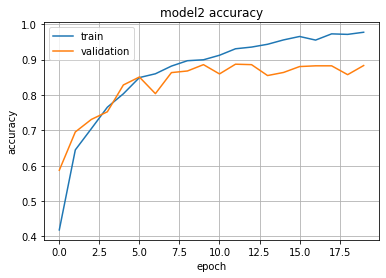

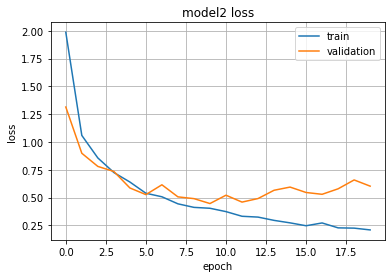

In [ ]:
plt.plot(m2.history['accuracy'])
plt.plot(m2.history['val_accuracy'])
plt.title('model2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

plt.plot(m2.history['loss'])
plt.plot(m2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()